# Classifying News Headlines

The purpose of this project is to correctly classify news headlines by training models on the News Aggregator Dataset found in the UCI ML Repository: http://archive.ics.uci.edu/ml/datasets/News+Aggregator. 

I will also include a function that allows the input of custom headlines (fake or real) and returns the suitable category.

## Import Libraries
Loading all libraries to be used

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score ,confusion_matrix,classification_report
from sklearn.feature_extraction.text import CountVectorizer
import itertools

## Data

This dataset contains headlines, URLs, and categories for 422,937 news stories collected by a web aggregator between March 10th, 2014 and August 10th, 2014.

News categories included in this dataset include business, science and technology, entertainment, and health. Different news articles that refer to the same news item are also categorized together.
## Load data
Lets load the data from  01.csv file.

In [2]:
news = pd.read_csv('01.csv')
news.head(5)

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


In [3]:
news['CATEGORY'].unique() # unique category labels

array(['b', 't', 'e', 'm'], dtype=object)

## The columns included in this dataset are:

ID : the numeric ID of the article <br>
TITLE : the headline of the article <br>
URL : the URL of the article <br>
PUBLISHER : the publisher of the article <br>
STORY : alphanumeric ID of the news story that the article discusses <br>
HOSTNAME : hostname where the article was posted <br>
TIMESTAMP : approximate timestamp of the article's publication, given in Unix time (seconds since midnight on Jan 1, 1970)

## CATEGORY : the category of the news item; one of:
b - business <br>
t - science and technology <br>
e - entertainment <br>
m - health <br>

## Visualizing the Data

Let's quickly see the distribution of news categories in this dataset via a pie chart.

(-1.101639420124838,
 1.1000780787490432,
 -1.1090927453255768,
 1.1174362845275305)

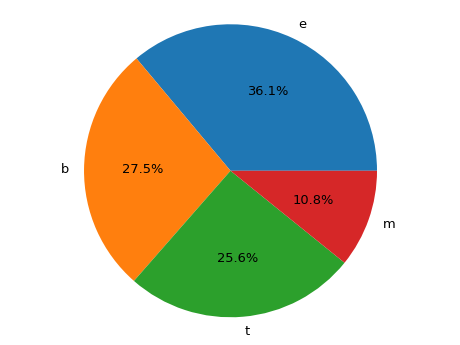

In [4]:
news.CATEGORY.value_counts().plot(kind='pie', 
                                  figsize=(8,6), 
                                  fontsize=13, 
                                  autopct='%1.1f%%', 
                                  wedgeprops={'linewidth': 5}
                                  )
plt.axis('off')
plt.axis('equal')

Not surprisingly, entertainment news is the biggest chunk of them all. 

Digging further, it's possible to get a sense of the most commonly occuring words within each news category. Using a word cloud accomplishes this, but let's also form the cloud in the shape of a category-relevant image - for style points.

First I'll remove all punctuation from the news titles, as well as making all words lower case; this should make it easier for the word cloud to pick off words, and (since I'm not sure if it's already built into the wordcloud) to ensure that similar instances of capitalized and uncaapitalized words aren't distinctly counted. 

### We will clean the title to remove special characters and punctuations

In [5]:
news['TITLE'] = news['TITLE'].str.replace('[^\w\s]','').str.lower() # unpunctuate and lower case

#### Using wordCload we can visualize our data.

<Figure size 432x288 with 0 Axes>

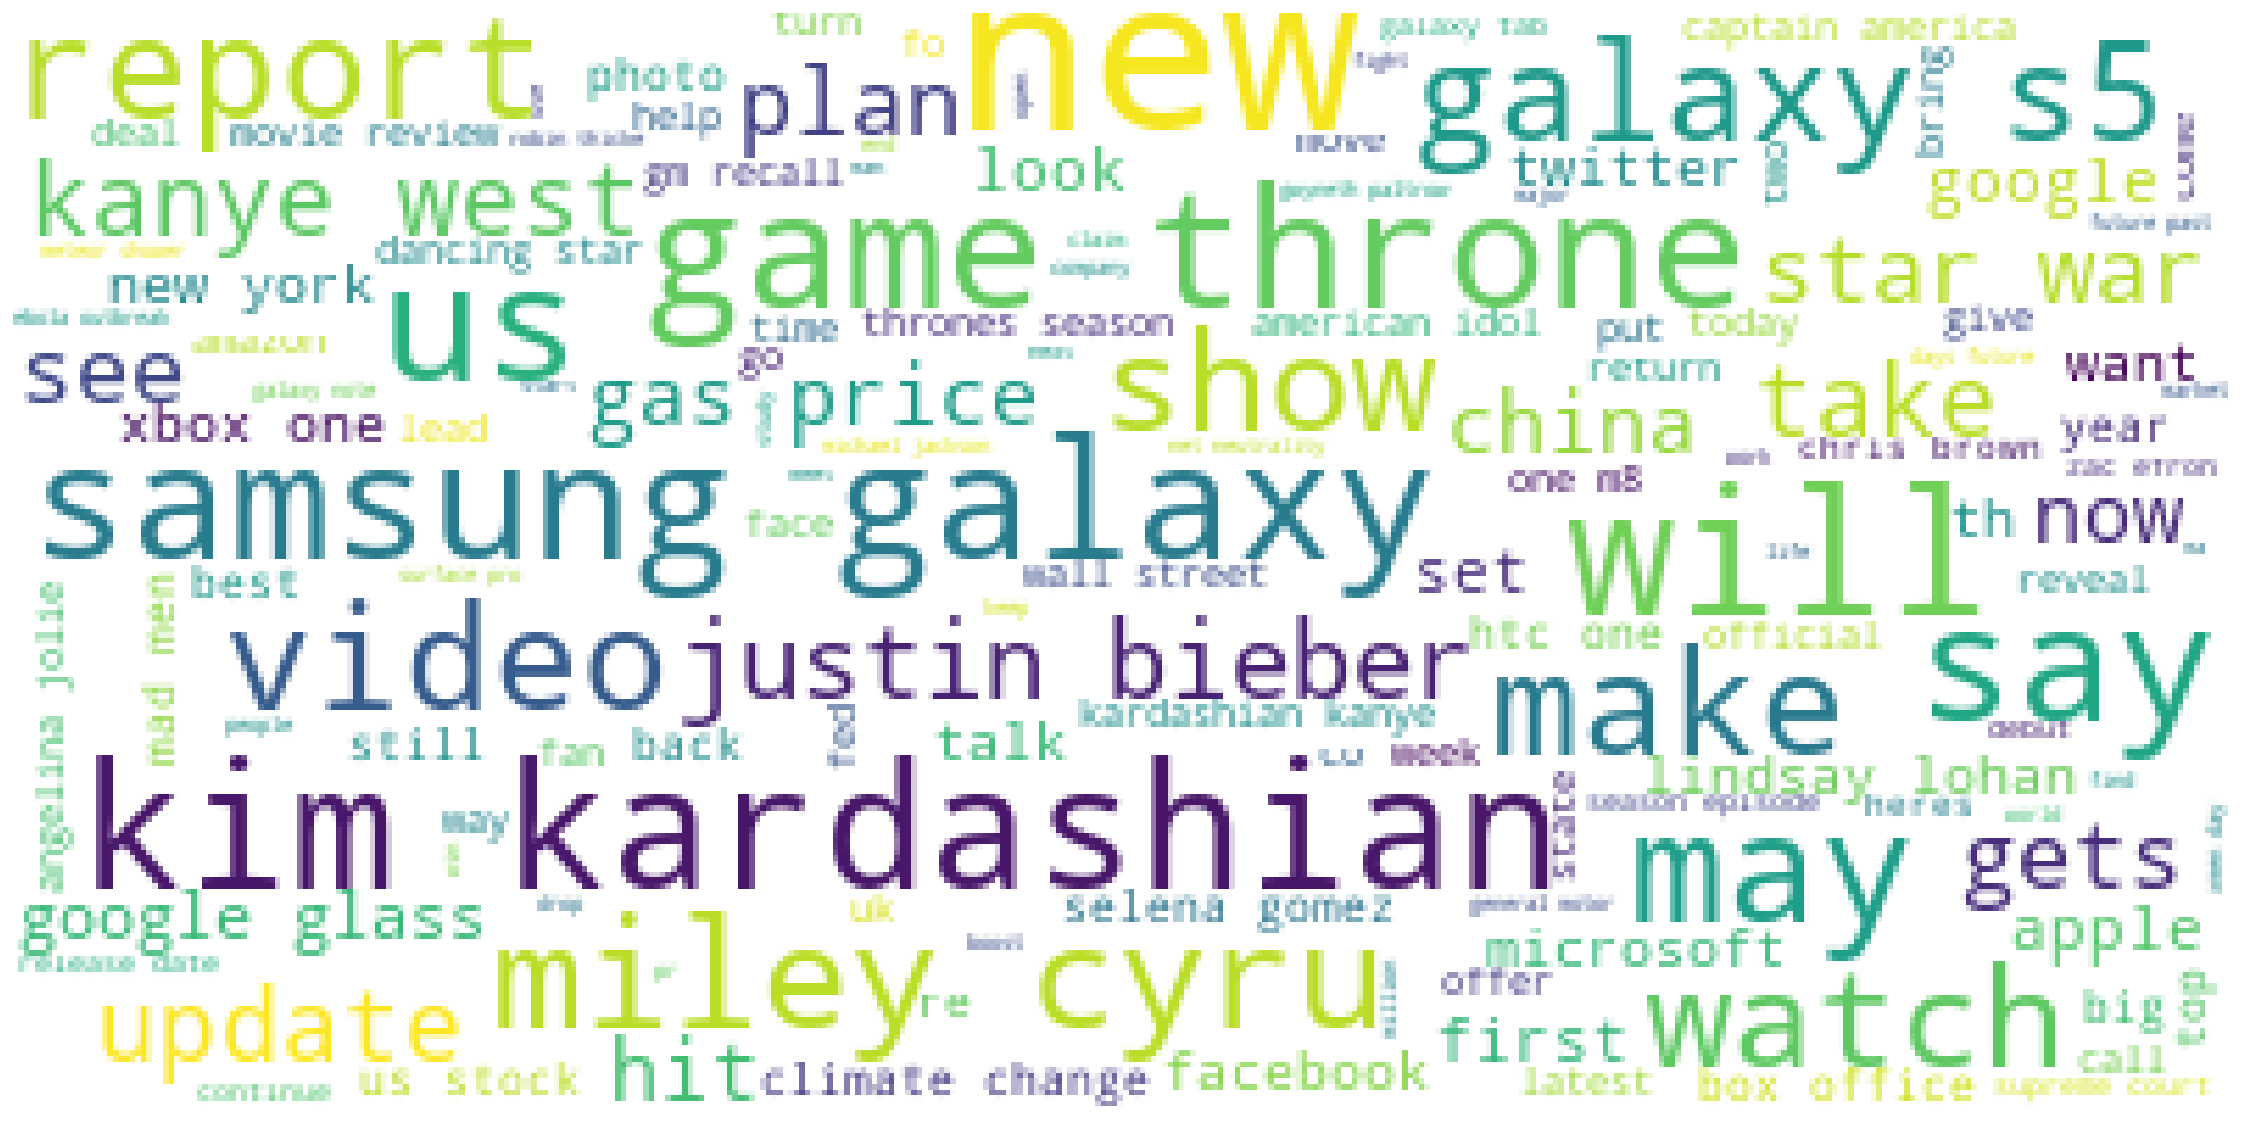

In [6]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from PIL import Image
b_title = news['TITLE'].to_string()
#fig = plt.figure(figsize=(20,20))
stopwords = set(STOPWORDS)
wordcloud = WordCloud().generate(b_title)
plt.figure()
plt.subplots(figsize=(40,25))
wordcloud = WordCloud(
    background_color="white",
    max_words=len(b_title),
    max_font_size=40,
    relative_scaling=.5).generate(b_title)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Some of the most common words appearing in news headlines (at laest in 2014) for each of the four categories have been:

Business: "stock", "US", "China" <br>
Entertainment: "star", "Kardashian", "Bieber" <br>
Science & Technology: "Facebook", "Google", "new" <br>
Health: "study", "Ebola", "cancer" 

This is reassuring. When we do use a function to return the categories of various headlines, the categories returned will make sense (if everything goes well). 

# Data Preprocessing
## Vectorization of data
Vectorize the data using Bag of words (BOW)

In [7]:
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(news['TITLE'])
y = news['CATEGORY']

Lets look at what exactly is this vectorizer doing. We will first create reverse dictionary from the vectorizer. Iterating over the vectorized sentence _Indian scientists are good_. We get the vector to be representative of three words "good", "indian" and "scientists". The order has been changed because bag of words does not preserve order.

In [8]:
reverse_vocabulary = {}
vocabulary = vectorizer.vocabulary_
for word in vocabulary:
    index = vocabulary[word]
    reverse_vocabulary[index] = word
    
vector = vectorizer.transform(iter(['Indian scientists are good']))
indexes = vector.indices
for i in indexes:
    print (reverse_vocabulary[i])

good
indian
scientists


## Split data
Split data into 2 parts - training and test. We will use training data to train out model . And finally use test data to see how our model performs

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 30% split
print("n_samples: %d, n_features: %d" % X_test.shape)
print("n_samples: %d, n_features: %d" % X_train.shape)

n_samples: 126726, n_features: 72048
n_samples: 295693, n_features: 72048


## Models

Let's test a couple of machine learning models.

### Baseline Model
“stratified”: generates predictions by respecting the training set's

In [10]:
dc = DummyClassifier(strategy="stratified")
dc.fit(X_train,y_train)
pred=dc.predict(X_test)
print(classification_report(y_test, pred, target_names=['b','e','m','t']))

              precision    recall  f1-score   support

           b       0.28      0.28      0.28     34867
           e       0.36      0.36      0.36     45653
           m       0.11      0.11      0.11     13665
           t       0.26      0.26      0.26     32541

    accuracy                           0.28    126726
   macro avg       0.25      0.25      0.25    126726
weighted avg       0.28      0.28      0.28    126726



An accuracy of 28% is not good. Let's see the confusion matrix to observe the model's behavior.

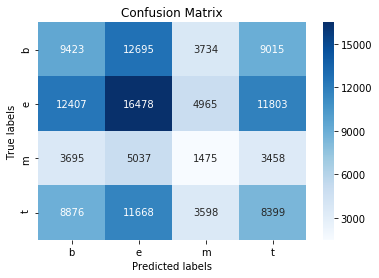

In [11]:
cf_matrix=confusion_matrix(y_test, dc.predict(X_test))
ax=plt.subplot()
sns.heatmap(cf_matrix,annot=True,ax=ax,cmap="Blues",fmt='')
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['b','e','m','t']);
ax.yaxis.set_ticklabels(['b','e','m','t']);
ax.set_ylim(4.0, 0)
plt.show()

Misclassifications occurs in almost every category, as they all account for over 500000 instanses of incorrect classification. 

Let's see if a stronger model can fix this.

### Preliminary Naive Bayes Approach
The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification).

In [12]:
mnb = MultinomialNB(alpha=0.1)
mnb.fit(X_train, y_train)
pred=mnb.predict(X_test)
print(classification_report(y_test, pred, target_names=['b','e','m','t']))

              precision    recall  f1-score   support

           b       0.91      0.91      0.91     34867
           e       0.97      0.96      0.97     45653
           m       0.91      0.92      0.92     13665
           t       0.91      0.91      0.91     32541

    accuracy                           0.93    126726
   macro avg       0.93      0.93      0.93    126726
weighted avg       0.93      0.93      0.93    126726



An accuracy of 93% is pretty good. Let's see the confusion matrix to observe the model's behavior.

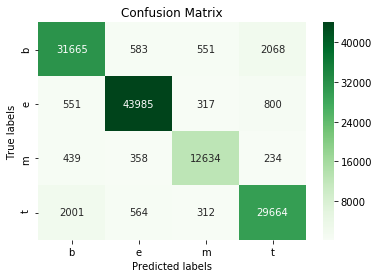

In [13]:
cf_matrix=confusion_matrix(y_test, mnb.predict(X_test))
ax=plt.subplot()
sns.heatmap(cf_matrix,annot=True,ax=ax,cmap="Greens",fmt='')
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['b','e','m','t']);
ax.yaxis.set_ticklabels(['b','e','m','t']);
ax.set_ylim(4.0, 0)
plt.show()

A majority of the misclassifications occur between the Business and Science & Technology categories, as they together account for over 4000 instanses of incorrect classification. 

Let's see if a stronger model can fix this.

### Linear Support Vector Classification.
The objective of a Linear SVC (Support Vector Classifier) is to fit to the data you provide, returning a "best fit" hyperplane that divides, or categorizes, your data

In [14]:
from sklearn.svm import LinearSVC
ls=LinearSVC(dual=False,tol=1e-3)
ls.fit(X_train,y_train)
pred=ls.predict(X_test)
print(classification_report(y_test, pred, target_names=['b','e','m','t']))

              precision    recall  f1-score   support

           b       0.92      0.93      0.93     34867
           e       0.97      0.97      0.97     45653
           m       0.95      0.93      0.94     13665
           t       0.93      0.93      0.93     32541

    accuracy                           0.95    126726
   macro avg       0.94      0.94      0.94    126726
weighted avg       0.95      0.95      0.95    126726



An accuracy of 95% is pretty good and highest till now. Let's see the confusion matrix to observe the model's behavior.

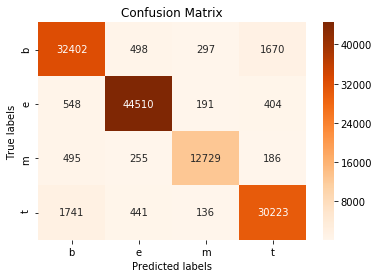

In [15]:
cf_matrix=confusion_matrix(y_test, ls.predict(X_test))
ax=plt.subplot()
sns.heatmap(cf_matrix,annot=True,ax=ax,cmap="Oranges",fmt='')
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['b','e','m','t']);
ax.yaxis.set_ticklabels(['b','e','m','t']);
ax.set_ylim(4.0, 0)
plt.show()

A majority of the misclassifications occur between the Business and Science & Technology categories, as they together account for over 3450 instanses of incorrect classification. 

Let's see if any other model can fix this.

### SGD Classifier

This estimator implements regularized linear models with stochastic gradient descent (SGD) learning: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing learning rate.

In [16]:
sgd=SGDClassifier(alpha=.0001, max_iter=50)
sgd.fit(X_train,y_train)
pred=sgd.predict(X_test)
print(classification_report(y_test, pred, target_names=['b','e','m','t']))

              precision    recall  f1-score   support

           b       0.92      0.92      0.92     34867
           e       0.96      0.98      0.97     45653
           m       0.95      0.90      0.92     13665
           t       0.92      0.92      0.92     32541

    accuracy                           0.94    126726
   macro avg       0.94      0.93      0.93    126726
weighted avg       0.94      0.94      0.94    126726



An accuracy of 94% is pretty good. Let's see the confusion matrix to observe the model's behavior and try to check
whether we can compromise accuracy of 95% for correctly classify news within Business and Science & Technology categories.

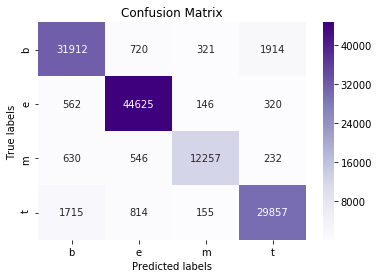

In [17]:
cf_matrix=confusion_matrix(y_test, sgd.predict(X_test))
ax=plt.subplot()
sns.heatmap(cf_matrix,annot=True,ax=ax,cmap="Purples",fmt='')
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['b','e','m','t']);
ax.yaxis.set_ticklabels(['b','e','m','t']);
ax.set_ylim(4.0, 0)
plt.show()

Looks like it's not so easy to correctly classify news within Business and Science & Technology categories. While the number of misclassified samples are lower - at roughly 3700 - it is possible that a degree of preprocessing or picking a better estimator could help improve model accuracy. 

### RidgeClassifier
This classifier first converts the target values into {-1, 1} and then treats the problem as a regression task (multi-output regression in the multiclass case).

In [18]:
rc=RidgeClassifier(tol=1e-2, solver="auto")
t0 = time()
rc.fit(X_train,y_train)
train_time = time() - t0
print("train time: %0.3fs" % train_time)
t0 = time()
pred=rc.predict(X_test)
test_time = time() - t0
print("test time:  %0.3fs" % test_time)
print(classification_report(y_test, pred, target_names=['b','e','m','t']))

train time: 7.151s
test time:  0.031s
              precision    recall  f1-score   support

           b       0.92      0.93      0.93     34867
           e       0.96      0.98      0.97     45653
           m       0.96      0.91      0.93     13665
           t       0.93      0.93      0.93     32541

    accuracy                           0.94    126726
   macro avg       0.94      0.94      0.94    126726
weighted avg       0.94      0.94      0.94    126726



An accuracy of 94% is pretty good. Let's see the confusion matrix to observe the model's behavior and try to check
whether we can compromise accuracy of 95% for correctly classify news within Business and Science & Technology categories.

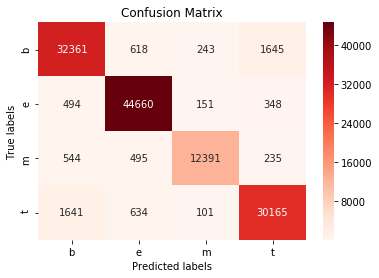

In [19]:
cf_matrix=confusion_matrix(y_test, rc.predict(X_test))
ax=plt.subplot()
sns.heatmap(cf_matrix,annot=True,cmap="Reds",ax=ax,fmt='')
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['b','e','m','t']);
ax.yaxis.set_ticklabels(['b','e','m','t']);
ax.set_ylim(4.0, 0)
plt.show()

Looks like it's not so easy to correctly classify news within Business and Science & Technology categories. While the number of misclassified samples are lower - at roughly 3400 - it is possible that a degree of preprocessing or picking a better estimator could help improve model accuracy.

# Final Model: Linear Support Vector Classification
**Linear Support Vector Classification** works the best. Lets run LS on our test data and understand the model.
## Predict test data

In [20]:
from sklearn.svm import LinearSVC
ls=LinearSVC(dual=False,tol=1e-3)
t0 = time()
ls.fit(X_train,y_train)
train_timels = time() - t0
print("Train time: %0.3fs" % train_time)
t0 = time()
pred=ls.predict(X_test)
test_timels = time() - t0
print("Test time:  %0.3fs" % test_time)

Train time: 7.151s
Test time:  0.031s


### Classification Report of Final Model

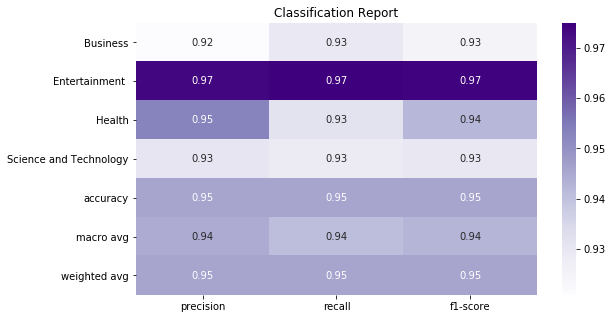

In [21]:
target_names = ['Business','Entertainment ','Health','Science and Technology']
clf_report = classification_report(y_test,ls.predict(X_test),
                                   target_names=target_names,
                                   output_dict=True)

fig, ax = plt.subplots(figsize=(9,5))
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1,:].T, annot=True,cmap="Purples")
ax.set_title('Classification Report');
ax.set_ylim(7.0,0)
plt.show()

### Linear Support Vector Classification Explained
We will now try to understand why Linear Support Vector Classification is getting good results. We will get all the coefficents of the features and then print the top 20 words based on its weight. As we can see all the words are closely related to the category, hence Linear Support Vector Classification predcits correct label with good F1 score.

In [22]:
ls = LinearSVC(dual=False,tol=1e-3)
ls.fit(X_train, y_train)
coefs = ls.coef_
target_names = target_names
for i in range(len(target_names)):
    words = []
    for j in coefs[i].argsort()[-20:]:
        words.append(reverse_vocabulary[j])
    print (target_names[i], '-', words, "\n")

Business - ['hillshire', 'yellen', 'barnes', 'srivatsa', 'hormel', 'geithner', 'windowspowered', 'piketty', 'actos', 'kaepernick', 'wean', 'marlboro', '350m', 'dimon', 'selfiefocused', 'derision', '96000', 'jerkcom', 'dimons', 'cocacola'] 

Entertainment  - ['kasems', 'jesus', 'avicii', 'bossy', 'disneyland', 'kardashian', 'transcendence', 'idol', 'garcetti', 'banksy', 'depp', 'jackman', 'aliyah', 'kanye', 'courtney', 'cinco', 'lionsgate', 'transformers', 'coachella', 'powdered'] 

Health - ['ecigarette', 'polio', 'leone', 'relay', 'rash', 'nutrients', 'stroke', 'humira', 'allergy', 'sarepta', 'icd10', 'ebola', 'poliofree', 'schumacher', 'sperm', 'promedica', 'smallpox', 'cdc', 'autism', 'mannkind'] 

Science and Technology - ['monuments', 'southsea', 'rex', 'costsharing', 'asteroids', 'amends', 'importer', 'nasa', 'mustang', 'asteroid', 'lg', 'ipcc', 'yuk', 'degrasse', 'nintendo', 'whaling', 'mozilla', 'cosmos', 'jetta', 'halo'] 



## Conclusion

I am quite happy with  the ~95% accuracy model, and build a simple function that takes in news titles while returning categories. Also shown are a few examples of the function in action. 


# Function for Custom headline

In [23]:
def title_to_category(title):
    categories = {'b' : 'Business', 
                  't' : 'Science and Technology', 
                  'e' : 'Entertainment', 
                  'm' : 'Health'}
    pridicter = ls.predict(vectorizer.transform([title]))
    return categories[pridicter[0]]

In [24]:
# sample predictions using our Linear Support Vector Classification on 2017 BBC headlines
print('news title', '                                 ', 'category', '\n' 
      'Bank of England staff to go on strike', '      ', title_to_category('Bank of England staff to go on strike'), '\n'
      'Trump stance could damage Earth - Hawking', '  ', title_to_category('Trump stance could damage Earth - Hawking'), '\n'
      'Olivia de Havilland sues over TV show', '      ', title_to_category('Olivia de Havilland sues over TV show')
     )

news title                                   category 
Bank of England staff to go on strike        business 
Trump stance could damage Earth - Hawking    science and technology 
Olivia de Havilland sues over TV show        entertainment


In [25]:
# testing a headline from The Onion
title_to_category("OneWeb increases mega-constellation to 74 satellites")

'science and technology'

In [26]:
# another one from The Onion
title_to_category("Spain's coronavirus death toll jumps 514 in 24 hours")

'health'

In [27]:
title_to_category("Tesla cuts staff pay as coronavirus halts production")

'business'